### Santander Dev Week 2023 (Pipeline ETL com Python)

**Contexto:** Você é um cientista de dados no Santander e recebeu a tarefa de envolver seus clientes de maneira mais personalizada. Seu objetivo é usar o poder da IA Generativa para criar mensagens de marketing personalizadas que serão entregues a cada cliente.

**Condições do Problema:**

1. Você recebeu uma planilha simples, em formato CSV ('SDW2023.csv'), com uma lista de IDs de usuário do banco:
  ```
  UserID
  1
  2
  3
  4
  5
  ```
2. Seu trabalho é consumir o endpoint `GET https://sdw-2023-prd.up.railway.app/users/{id}` (API da Santander Dev Week 2023) para obter os dados de cada cliente.
3. Depois de obter os dados dos clientes, você vai usar a API do ChatGPT (OpenAI) para gerar uma mensagem de marketing personalizada para cada cliente. Essa mensagem deve enfatizar a importância dos investimentos.
4. Uma vez que a mensagem para cada cliente esteja pronta, você vai enviar essas informações de volta para a API, atualizando a lista de "news" de cada usuário usando o endpoint `PUT https://sdw-2023-prd.up.railway.app/users/{id}`.

In [4]:
# Repositório da API: https://github.com/digitalinnovationone/santander-dev-week-2023-api
sdw2023_api_url = 'https://sdw-2023-prd.up.railway.app'

In [3]:
# 1º Passo: 
# Acessar API - https://sdw-2023-prd.up.railway.app/swagger-ui/index.html
# Criar novos registros/usuários através da função POST, disponível na API
# Guardar os IDs que foram gerados para os novos usuários
# Criar uma planilha para armazenar a lista de IDs, nome da coluna = UserID, salvar os IDs gerados via API


### **E**xtract
Extraia a lista de IDs de usuário a partir do arquivo CSV. Para cada ID, faça uma requisição GET para obter os dados do usuário correspondente.

In [5]:
import pandas as pd

df = pd.read_csv('SDW2023.csv')

# acessando os IDs dentro da base
user_ids = df['UserID'].tolist()
user_ids

[6006, 6007, 6008]

In [6]:
# Chamando endpoint da API e buscar id do usuário com GET
import requests
import json

def get_user(id):
    response = requests.get(f'{sdw2023_api_url}/users/{id}')
    return response.json() if response.status_code == 200 else None

# buscando usuário com list comprehension da API
# operator walrus para fazer atribuição de valores para a função
users = [user for id in user_ids if (user := get_user(id)) is not None]
print(json.dumps(users, indent=2))

[
  {
    "id": 6006,
    "name": "Caio Castro Pai",
    "account": {
      "id": 6352,
      "number": "300023-1",
      "agency": "0025",
      "balance": 0.0,
      "limit": 1000.0
    },
    "card": {
      "id": 5835,
      "number": "xxxx xxxx xxxx 9860",
      "limit": 0.0
    },
    "features": [],
    "news": []
  },
  {
    "id": 6007,
    "name": "Caio Castro Filho",
    "account": {
      "id": 6353,
      "number": "300024-1",
      "agency": "0025",
      "balance": 0.0,
      "limit": 1000.0
    },
    "card": {
      "id": 5836,
      "number": "xxxx xxxx xxxx 9861",
      "limit": 1000.0
    },
    "features": [],
    "news": []
  },
  {
    "id": 6008,
    "name": "Caio Castro Neto",
    "account": {
      "id": 6354,
      "number": "300025-1",
      "agency": "0025",
      "balance": 0.0,
      "limit": 1000.0
    },
    "card": {
      "id": 5837,
      "number": "xxxx xxxx xxxx 9862",
      "limit": 1000.0
    },
    "features": [],
    "news": []
  }
]


### **T**ransform
Utilize a API do OpenAI GPT-4 para gerar uma mensagem de marketing personalizada para cada usuário.

In [7]:
import os
from dotenv import load_dotenv

# Documentação Oficial da API OpenAI: https://platform.openai.com/docs/api-reference/introduction
# Informações sobre o Período Gratuito: https://help.openai.com/en/articles/4936830

# Para gerar uma API Key:
# 1. Crie uma conta na OpenAI
# 2. Acesse a seção "API Keys"
# 3. Clique em "Create API Key"
# Link direto: https://platform.openai.com/account/api-keys

# Carrega as variáveis do arquivo .env no ambiente de trabalho
load_dotenv()

# Utilizando arquivo .env para armazenar a API Key
openai_api_key = os.getenv('openai_api_key')

In [9]:
import openai

openai.api_key = openai_api_key

# função que cria mensagem personalizada para usuário utilizando IA
def generate_ai_news(user):
    # implementando código para o endpoint do chat API seguindo a documentação como referência
    completion = openai.ChatCompletion.create(
        model="gpt-4",
        messages=[
        {
            "role": "system",
            # Passando orientação para o chatgpt
            "content": "Você é um especialista em marketing bancário."
        },
        {
            "role": "user",
            # Solicitando mensagem personalizada e específica para o assunto de interesse
            "content": f"Crie uma mensagem para {user['name']} sobre a importância dos investimentos (máximo de 100 caracteres)"
        }
        ]
    )

    # Acessando resposta do chatgpt utilizando documentação da API de referência
    return completion.choices[0].message.content.strip('\"')

# Chamando função para a lista de usuários
for user in users:
    # criando a mensagem personalizada para cada usuário
    news = generate_ai_news(user)
    print(news)
    # adicionando informação dentro da API
    user['news'].append({
      "icon": "https://digitalinnovationone.github.io/santander-dev-week-2023-api/icons/credit.svg",
      "description": news
  })

Caio, invista no futuro da sua família. Comece hoje e colha os frutos amanhã. #InvestimentoÉVida
Caio, investir é garantir seu futuro! Precisamos conversar sobre as melhores opções para você.
Caio, investir é aumentar seu potencial financeiro. Não deixe o futuro ao acaso. Invista!


### **L**oad
Atualize a lista de "news" de cada usuário na API com a nova mensagem gerada.

In [10]:
def update_user(user):
    response = requests.put(f'{sdw2023_api_url}/users/{user["id"]}', json=user)
    return True if response.status_code == 200 else False

for user in users:
    success = update_user(user)
    print(f'User {user["name"]} updated? {success}!')

User Caio Castro Pai updated? True!
User Caio Castro Filho updated? True!
User Caio Castro Neto updated? True!


No print abaixo confirmamos que os dados foram carregados na API de destino

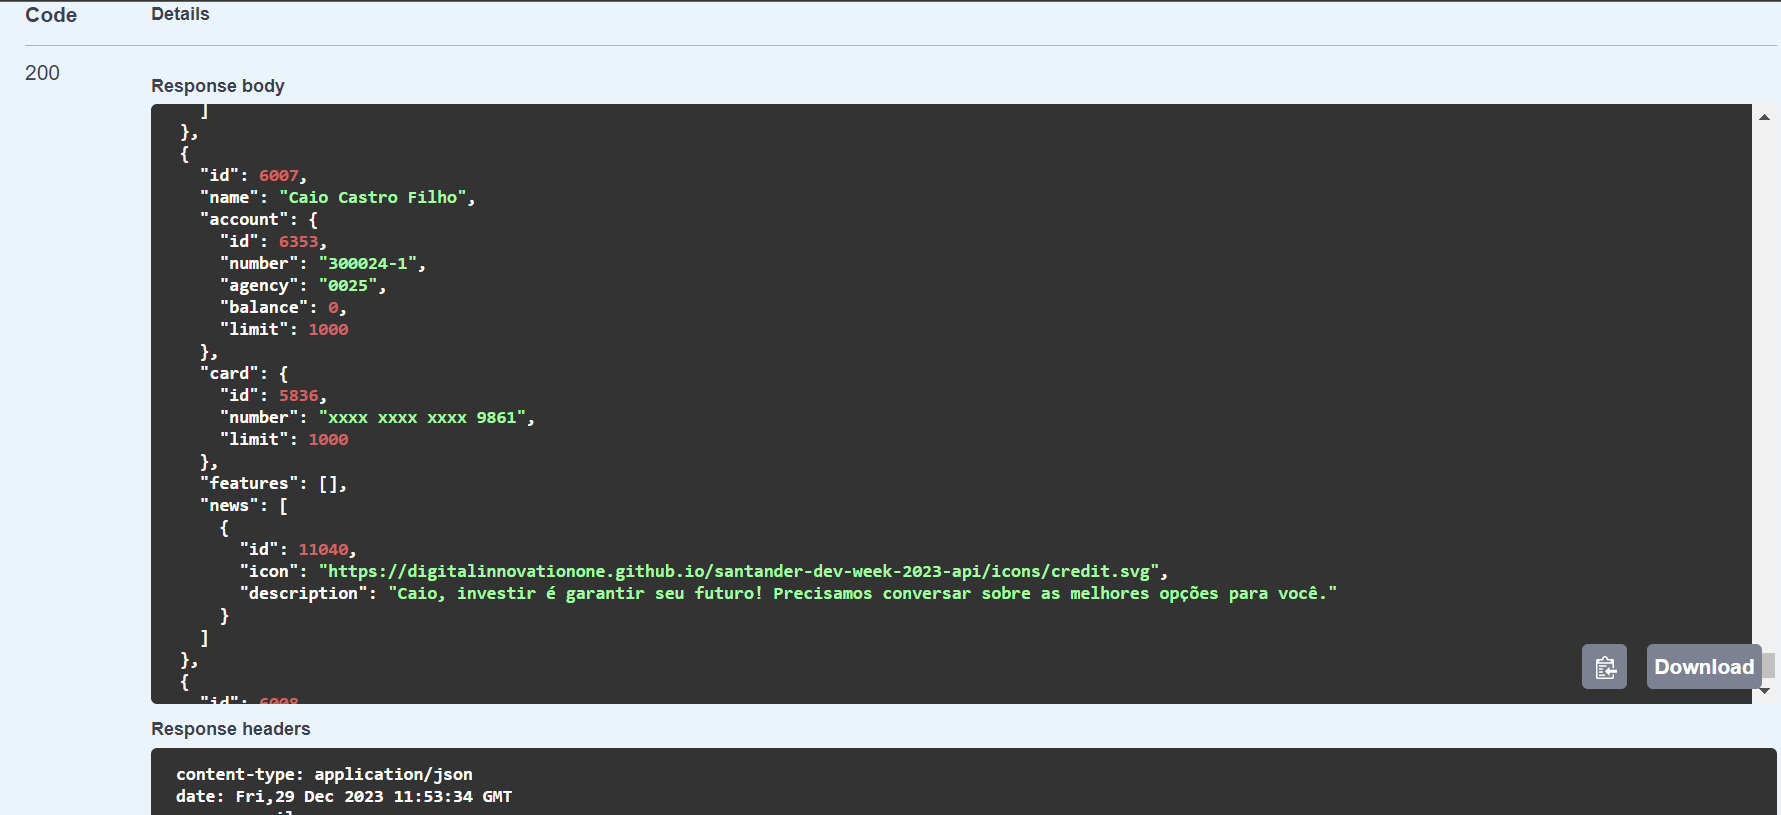